# Compressing and Decompressing Data

This notebook gives an example of how to use the compressor and the decompressor.

In [6]:
import numpy as np
import time
import xarray as xr
import matplotlib.pyplot as plt
from lossycomp.compress import compress
from lossycomp.decompress import decompress
from lossycomp.plots import single_plot
from lossycomp.encodings import encode_lat, encode_lon

## Reading Data

In [7]:
data_or = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc', combine='by_coords')
data_or = data_or.sel(time=slice('1980-10-14T16:00:00','1980-10-15T07:00:00'),level = slice(978,1000), longitude=slice(-180,180), latitude=slice(90,-90))
data_or = data_or.transpose('time', 'latitude', 'longitude', 'level')
#data_or = data_or['t'].values
#data_or.shape

In [8]:
# In case we use the extra information:
lat = data_or['t'].coords['latitude'].values
lon = data_or['t'].coords['longitude'].values

lat_st = np.stack([encode_lat(x) for x in lat])
lon_st = np.stack([encode_lon(x) for x in lon])

lat1, lat2 = np.hsplit(lat_st, 2)
lon1, lon2 = np.hsplit(lon_st, 2)

xx, yy = np.meshgrid(lon1, lat1)
xx2, yy2 = np.meshgrid(lon2, lat2)

coords_lat = np.concatenate([[xx]] * len(data_or.time), axis=0)
coords_lon = np.concatenate([[yy]] * len(data_or.time), axis=0)
coords_lat1 = np.concatenate([[xx2]] * len(data_or.time), axis=0)
coords_lon1 = np.concatenate([[yy2]] * len(data_or.time), axis=0)

coords_lat = np.expand_dims(coords_lat, axis=3)
coords_lon = np.expand_dims(coords_lon, axis=3)

coords_lat1 = np.expand_dims(coords_lat1, axis=3)
coords_lon1 = np.expand_dims(coords_lon1, axis=3)

temp = data_or['t'].values
data_or =  np.concatenate((temp, coords_lat, coords_lon, coords_lat1, coords_lon1 ),axis = 3)

data_or.shape

(16, 721, 1440, 5)

## Compress

In [26]:
compressed_data = compress(data_or, 0.5, extra_channels = True, verbose = True)

Load model...
Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 16, 48, 48, 5)]   0         
_________________________________________________________________
Encoder (Functional)         (None, 1, 3, 3, 20)       67270     
_________________________________________________________________
Decoder (Functional)         (None, 16, 48, 48, 1)     64691     
Total params: 131,961
Trainable params: 131,961
Non-trainable params: 0
_________________________________________________________________
None
Standardizing data...
Chunking data...
Compressing data...
Merging data...
Quantizing data...
Encoding data...
Compression factor: 29.639415163672275
Latent space compression factor: 1024.0
Latent space (%): 0.11517287373447861
Error space (%): 0.8848271262655214


In [12]:
val = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1]
count = []
times = []
dataa = np.array(data_or[:,:,:,0], dtype= np.float32)
vls = []
for i in val:
    compressed_data = compress(data_or, i,  extra_channels = True)
    cf = dataa.nbytes /len(compressed_data)
    vls.append(cf)
vls

[3.1881419629265535,
 5.1931656943585285,
 11.517659726560414,
 16.180705112283214,
 20.608810624333753,
 28.93755119798383,
 38.97077867237205,
 44.53874924592801,
 50.301792465256696,
 56.22617273671144]

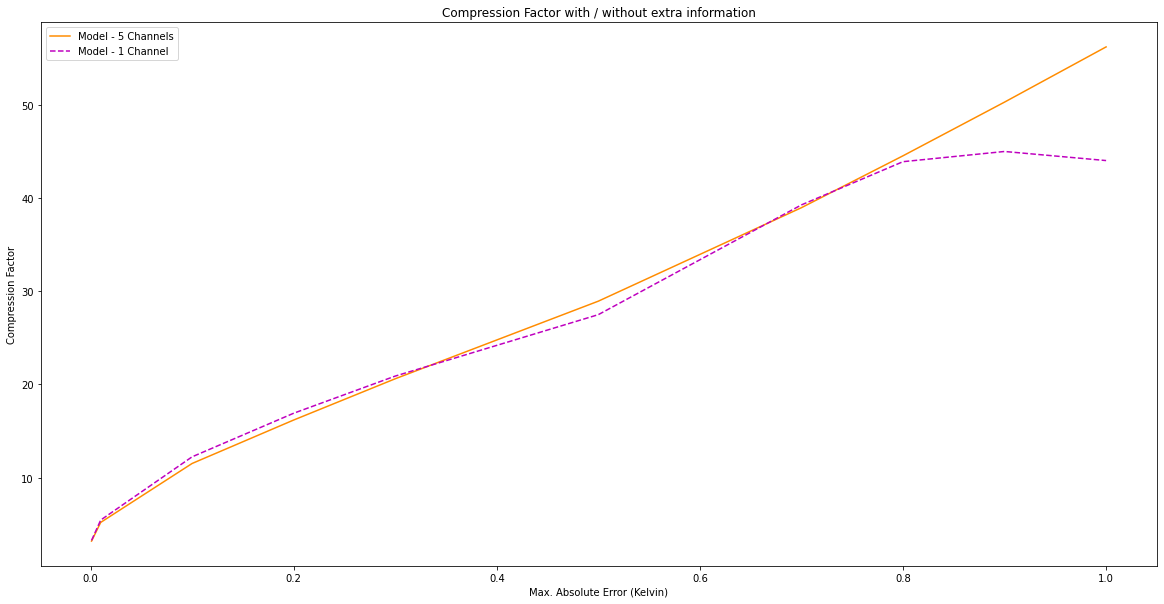

In [13]:
val_5 =[3.1881419629265535,
 5.1931656943585285,
 11.517659726560414,
 16.180705112283214,
 20.608810624333753,
 28.93755119798383,
 38.97077867237205,
 44.53874924592801,
 50.301792465256696,
 56.22617273671144]

val_1 = [3.263554665484635,
 5.445422082461307,
 12.232133702073028,
 16.90985075477681,
 20.896322761480935,
 27.49088255238059,
 39.269702265322444,
 43.90900133945947,
 45.00313916986397,
 44.0285504522962]

val = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1]

plt.figure(figsize=(20,10))
#plt.plot(val, all_values, 'b', label = "Our Model - All values")
#plt.plot(val, abs_values, '--g', label = "Out Model - Abs. values")
#plt.plot(val3, mft_values, '*r', label = "Out Model - Abs. values + MTF")
#plt.plot(val2, SZ, 'r',  label = "SZ")

plt.plot(val, val_5, 'darkorange', label = "Model - 5 Channels")
plt.plot(val, val_1, '--m',  label = "Model - 1 Channel")
#plt.plot(val, ZFP, 'c',label = "ZFP")


#plt.axvline(x=15.740921)
plt.title('Compression Factor with / without extra information')
plt.xlabel('Max. Absolute Error (Kelvin)')
plt.ylabel('Compression Factor')
plt.legend(loc="upper left")

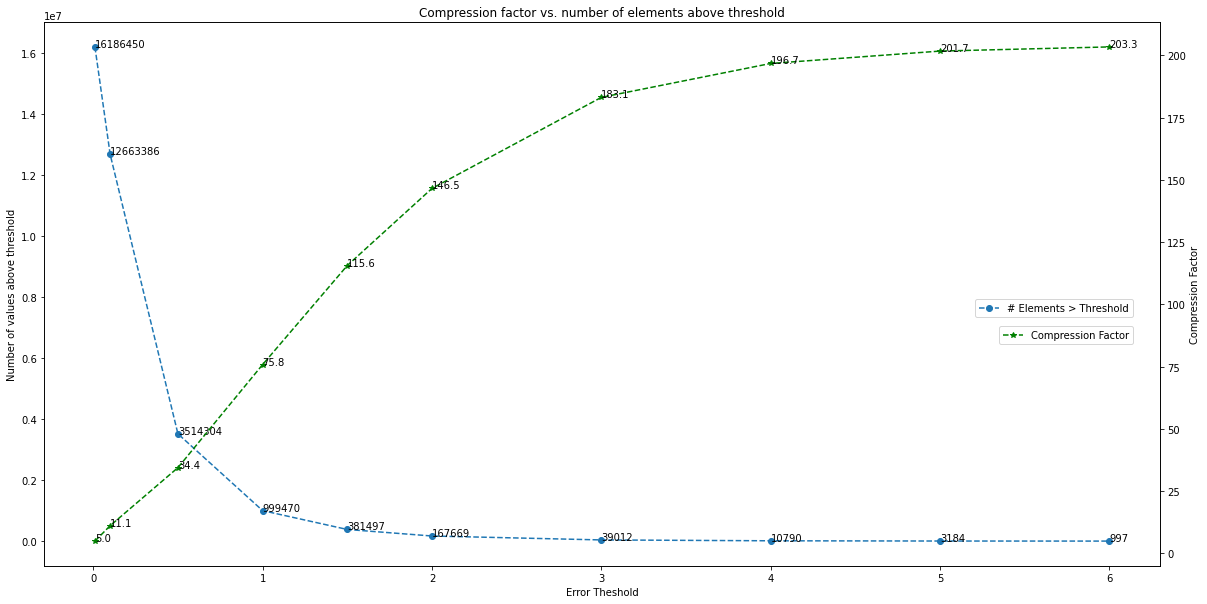

In [227]:
fig, ax = plt.subplots(figsize=[20,10])

#Set axis labels
ax.set_xlabel('Error Theshold')
ax.set_ylabel('Number of values above threshold')

ax2y = ax.twinx()
ax2y.set_ylabel("Compression Factor")

p1, = ax.plot(val, count,  "--o", label = "# Elements > Threshold")
p2, = ax2y.plot(val, cf,  "--*g", label = "Compression Factor")


for xy in zip(val, count):                                
    ax.annotate('%s' % xy[1], xy=xy, textcoords='data') 
    
for xy in zip(val, cf):                                
    ax2y.annotate('%.1f' % xy[1], xy=xy, textcoords='data') 
    

ax.legend(bbox_to_anchor=(0.98, 0.5))
ax2y.legend(bbox_to_anchor=(0.98, 0.45))
ax.title.set_text('Compression factor vs. number of elements above threshold')

plt.show()

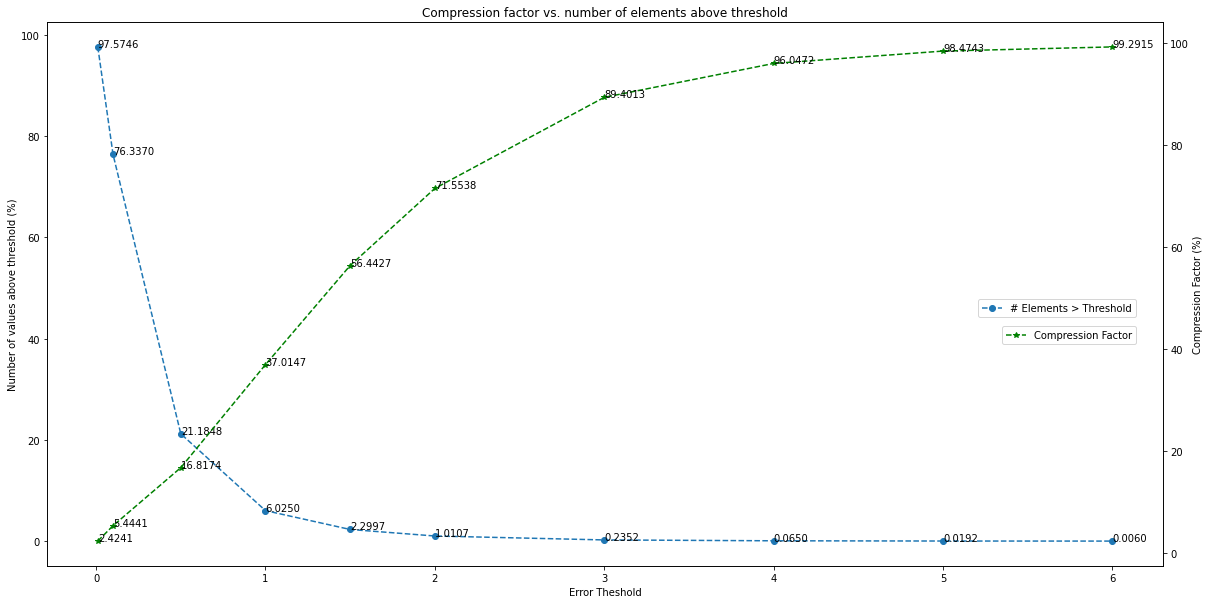

In [223]:
fig, ax = plt.subplots(figsize=[20,10])

#Set axis labels
ax.set_xlabel('Error Theshold')
ax.set_ylabel('Number of values above threshold (%)')

ax2y = ax.twinx()
ax2y.set_ylabel("Compression Factor (%)")

count_per = (np.array(count) / len(abs_err.flatten())) *100
cf_per = (np.array(cf) / 204.8 ) * 100

p1, = ax.plot(val, count_per,  "--o", label = "# Elements > Threshold")
p2, = ax2y.plot(val, cf_per,  "--*g", label = "Compression Factor")


for xy in zip(val, count_per):                                
    ax.annotate('%.4f' % xy[1], xy=xy, textcoords='data') 
    
for xy in zip(val, cf_per):                                
    ax2y.annotate('%.4f' % xy[1], xy=xy, textcoords='data') 
    

ax.legend(bbox_to_anchor=(0.98, 0.5))
ax2y.legend(bbox_to_anchor=(0.98, 0.45))
ax.title.set_text('Compression factor vs. number of elements above threshold')

plt.show()

In [210]:
np.array(count) / len(abs_err.flatten())
np.array(cf) / 204.8

array([0.02424147, 0.05444126, 0.16817418, 0.37014696, 0.56442748,
       0.71553822, 0.8940126 , 0.96047241, 0.98474257, 0.99291476])

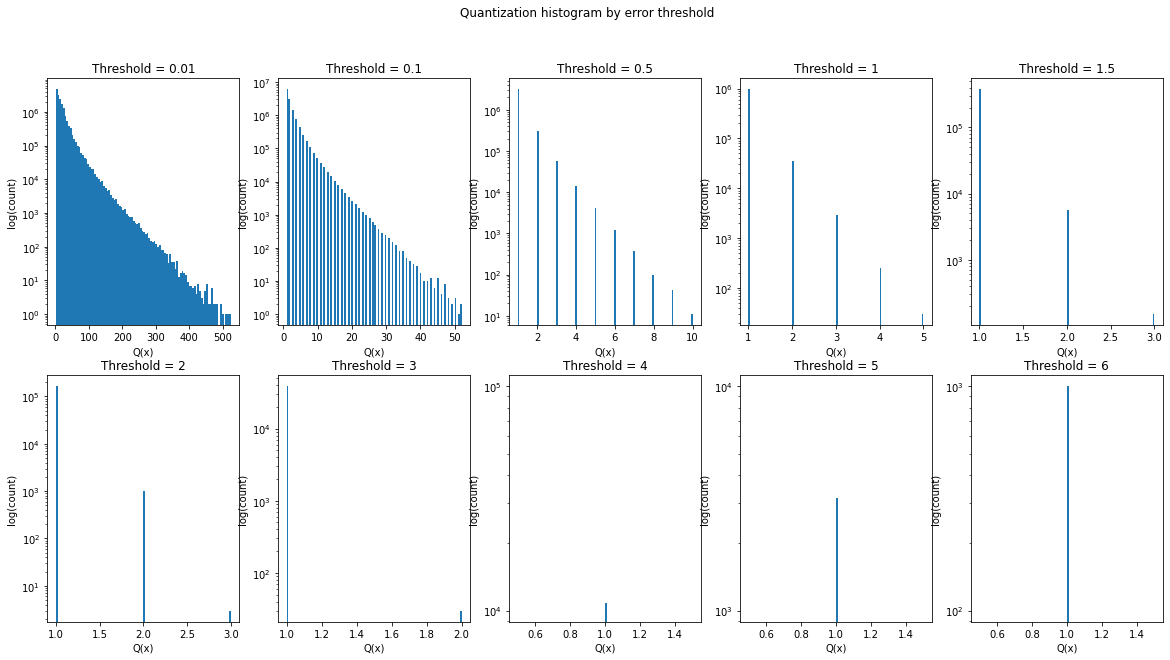

In [16]:
fig, axs = plt.subplots(2, 5, figsize=[20,10])
fig.suptitle('Quantization histogram by error threshold')
cnt = 0
for i in range(2):
    for j in range(5):
        axs[i, j].hist(vls[cnt],100)
        axs[i, j].set_yscale('log')
        title = "Threshold = " + str(val[cnt])
        axs[i, j].set_title( title)
        cnt = cnt + 1

for ax in axs.flat:
    ax.set(xlabel='Q(x)', ylabel='log(count)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
    



In [27]:
decompressed_data = decompress(compressed_data)

(1, 16, 721, 1440, 1)


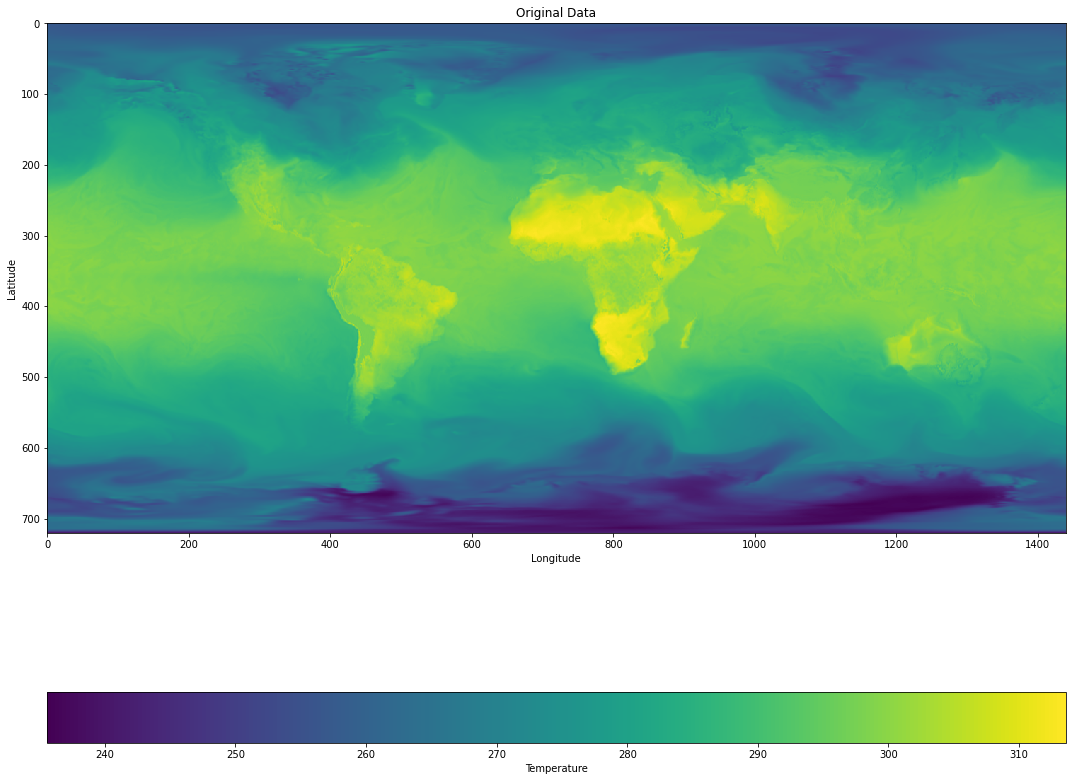

In [28]:
data_r = np.expand_dims(data_or[:,:,:,0], axis=0)
#data_r = np.expand_dims(data_or, axis=0)
data_r = np.expand_dims(data_r, axis=4)
print(data_r.shape)
single_plot(data_r, 0, "Original Data", "Temperature", data_r[0,0].min(), data_r[0,0].max())

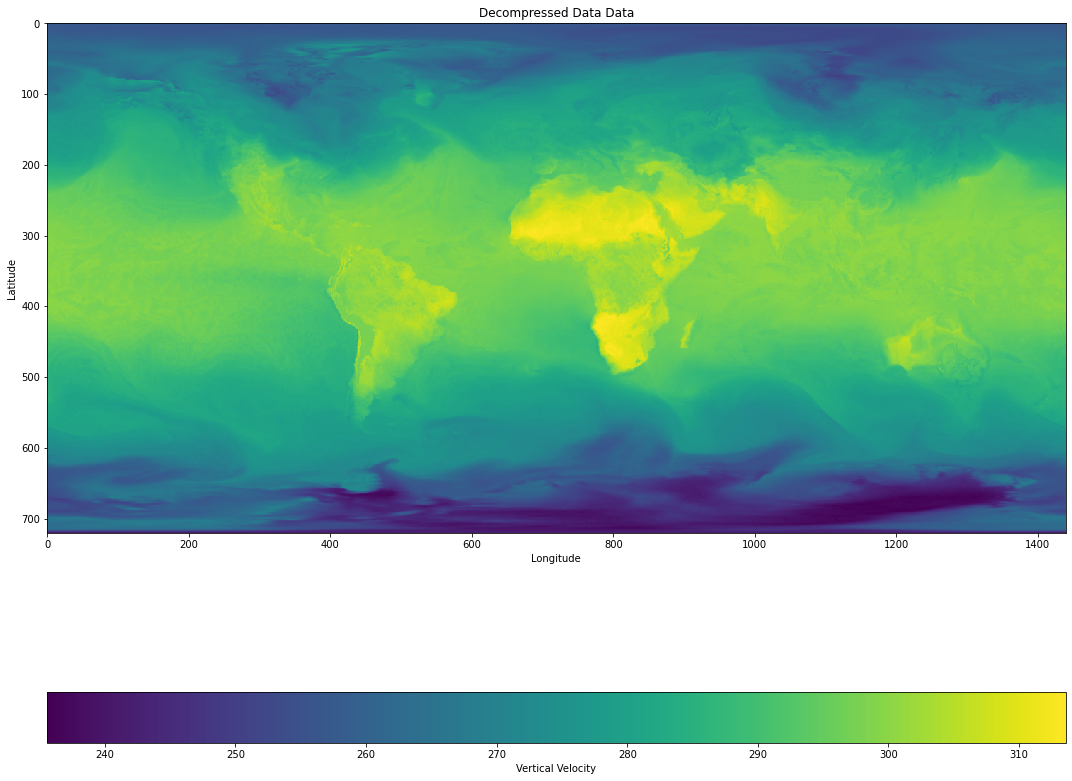

In [29]:
decom = np.expand_dims(decompressed_data, axis=0)
single_plot(decom, 0, "Decompressed Data Data", "Vertical Velocity", data_r[0,0].min(), data_r[0,0].max())

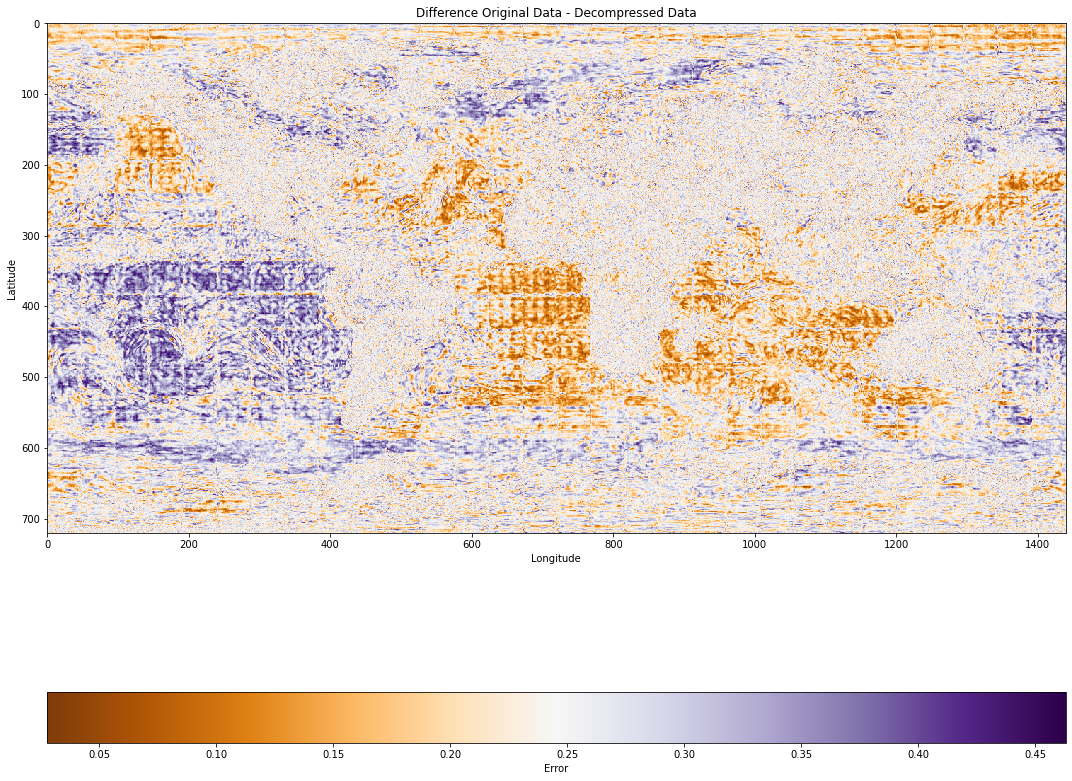

In [31]:
diff = np.abs(data_r-decom)

diff = np.mean(diff, axis = 1)
diff = np.expand_dims(diff, axis=0)

# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

single_plot(diff, 0, "Difference Original Data - Decompressed Data", "Error", diff.min(), diff.max(), cmap=cmap)

(array([215128., 215597., 215652., 215638., 215531., 215347., 213507.,
        214490., 212984., 212065., 212955., 211911., 210113., 210110.,
        210250., 208420., 207586., 207296., 205776., 206018., 204094.,
        202082., 202585., 201456., 199197., 198764., 197919., 196532.,
        195362., 194545., 191956., 191354., 190800., 188146., 187414.,
        185749., 185555., 182189., 181622., 180163., 178434., 177297.,
        175957., 173831., 172896., 172239., 169340., 168142., 167832.,
        165441., 163780., 162194., 161546., 159271., 157866., 156547.,
        154190., 153465., 151595., 150374., 149079., 148063., 146298.,
        145181., 143203., 142002., 141621., 139966., 138406., 137782.,
        137251., 135177., 134919., 133993., 132609., 131599., 131593.,
        130398., 128956., 128517., 127425., 126400., 126763., 125929.,
        125695., 124594., 124836., 123680., 124394., 123129., 122744.,
        122257., 121691., 121964., 121498., 122037., 120684., 121079.,
      

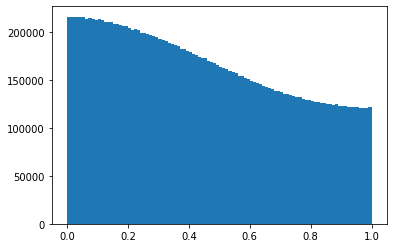

In [24]:

plt.hist(diff.flatten(),100)

## Some statistics


Data Original
Mean: 280.2641119769467
Variance: 286.2916231462562
Max Val: 313.56591796875
Min Val: 234.85653686523438

Decompressed
Mean: 280.2966945516455
Variance: 283.81150750840806
Max Val: 314.4129333496094
Min Val: 234.0828094482422

Error
Mean: 0.4422877001981005
Variance: 0.08060928433551794
Max error: 1.0
Min error: 0.0



Text(0, 0.5, 'Count')

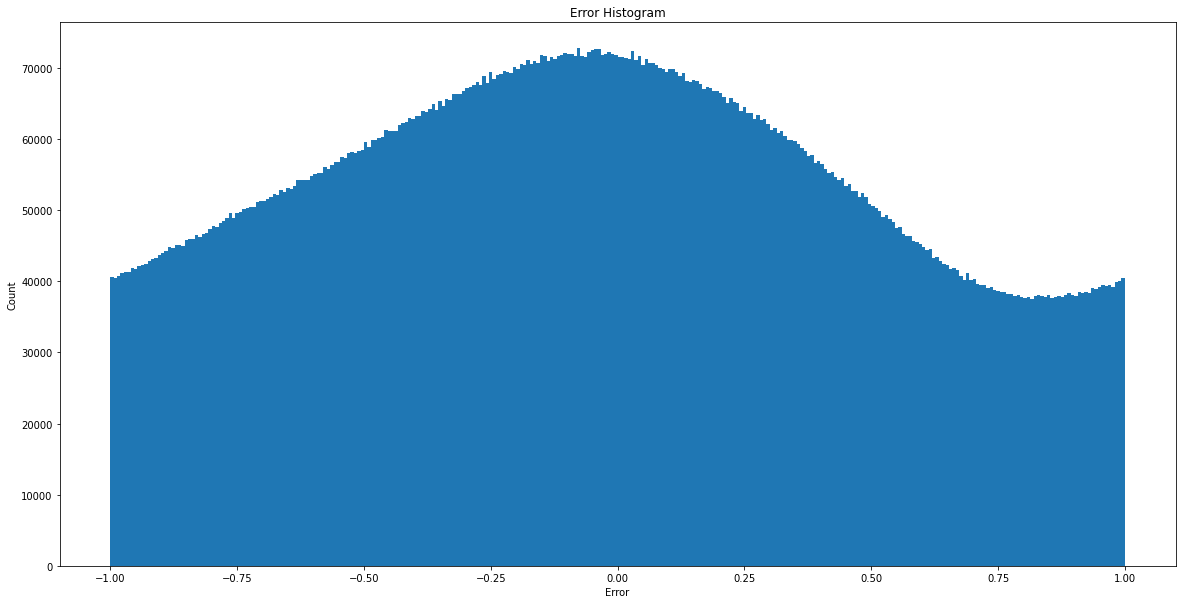

In [25]:
#original = data[:,0:720,:,:]
decom = decompressed_data 
#diff = original - decom
original = data_r

print("")
print("Data Original")
print("=======")
print("Mean:", original.mean())
print("Variance:", original.var())
print("Max Val:", original.max())
print("Min Val:", original.min())
print("")
print("Decompressed")
print("=======")
print("Mean:", decom.mean())
print("Variance:", decom.var())
print("Max Val:", decom.max())
print("Min Val:", decom.min())
print("")
print("Error")
print("=======")
print("Mean:", diff.mean())
print("Variance:", diff.var())
print("Max error:", diff.max())
print("Min error:", diff.min())
print("")



diff2 = data_r-decom
plt.figure(figsize=(20,10))
plt.hist(diff2.flatten(),300)
plt.title('Error Histogram')
plt.xlabel('Error')
plt.ylabel('Count')

In [27]:
decompressed_data.shape

(256, 720, 1440, 1)

In [5]:
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return ("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

val = [0.01, 0.1, 0.5, 1, 1.5, 2, 3, 4, 5, 6]
cf = []
times = []
for i in val:
    start = time.time()
    compressed_data = compress(data_or[:,0:672,0:1392,:], i)
    end = time.time()
    print(i)
    times.append(timer(start, end))
    cf.append(data_or[:,0:672,0:1392,:].nbytes/len(compressed_data))
cf

0.01
0.1
0.5
1
1.5
2
3
4
5
6


[4.909928880948499,
 10.986460700282281,
 34.07355618706236,
 72.8673220617071,
 111.32293377019184,
 143.21527575103704,
 186.2832001045501,
 208.1234825414042,
 219.1747184676439,
 224.52673859966922]

In [6]:
abs_values = [4.938892048076551,
 11.097438072451645,
 34.07804416086247,
 70.68516090133295,
 104.24913512205698,
 131.12717054286543,
 166.6910340565675,
 186.13011537199262,
 195.59842236515524,
 200.24081333345404,
 202.41043239533286,
 203.47926881997407,
 203.97779321623332,
 204.274183121225,
 204.35030319081773,
 204.42018225396023,
 204.44978509035448,
 204.46616481115709,
 204.48380744589386,
 204.4888487579085,
 204.4888487579085]

all_values = [5.3757056427847685,
 12.35069349246704,
 36.643487634413354,
 74.46938409050098,
 108.28869936451673,
 134.7970584650388,
 168.85348940772315,
 187.22827927134827,
 196.35375824487997,
 200.6307202486598,
 202.59768809423488,
 203.58477483171438,
 204.0813062640516,
 204.34401012555315,
 204.41829300226428,
 204.4938903185047,
 204.52351450816488,
 204.53990604539905,
 204.5575614087008,
 204.563867634274,
 204.563867634274]

mft_values =[3.9583911734138177,
 9.661502620850321,
 35.1145724904309,
 73.87863031848268,
 134.15389592010027,
 168.10105032756235,
 186.5891311561152,
 200.24504330506684,
 202.3740103207232,
 203.95146120461783,
 204.41703352053406,
 204.48191701797205]

compress_laten = [4.909928880948499,
 10.986460700282281,
 34.07355618706236,
 72.8673220617071,
 111.32293377019184,
 143.21527575103704,
 186.2832001045501,
 208.1234825414042,
 219.1747184676439,
 224.52673859966922]


In [ ]:
BZIP =[ 1.8289936474808461,
 2.2475215776493758,
 7.067877623564193,
 18.633793632937135,
 35.05420958291665,
 55.443757614041424,
 146.84739911256682,
 175.46394478673614,
 201.58643841234638,
 203.78359785759915,
 204.28864785983234,
 204.41892274894948,
 204.47372556753575,
 204.47372556753575]

BZIP_TIMES = ['00:00:06.06',
 '00:00:05.15',
 '00:00:02.34',
 '00:00:01.60',
 '00:00:01.90',
 '00:00:01.61',
 '00:00:01.28',
 '00:00:01.24',
 '00:00:01.23',
 '00:00:01.24',
 '00:00:01.25',
 '00:00:01.24',
 '00:00:01.24',
 '00:00:01.24']

ZLIB = [1.4402215340762485,
 1.743937682990694,
 5.505757317934684,
 14.407510164803789,
 26.960178447361685,
 43.39229907539467,
 120.16450472018442,
 145.6969521312685,
 168.25023327518358,
 170.05433111225014,
 170.46454692352947,
 170.58286695579076,
 170.61225329370262,
 170.61225329370262]

ZLIB_TIMES = ['00:00:12.15',
 '00:00:18.73',
 '00:00:05.88',
 '00:00:02.84',
 '00:00:02.38',
 '00:00:02.25',
 '00:00:01.29',
 '00:00:01.15',
 '00:00:01.03',
 '00:00:01.14',
 '00:00:01.00',
 '00:00:01.00',
 '00:00:01.00',
 '00:00:01.00']

GZIP = [1.440262954258554,
 1.7439502874086066,
 5.505769195664764,
 14.408004446914953,
 26.96098906367577,
 43.39099382110972,
 120.20826011499959,
 145.68767537138115,
 168.24724702135697,
 170.04953730161375,
 170.45929206495185,
 170.57760479996298,
 170.6069893247218,
 170.6069893247218]


GZIP_TIMES = ['00:00:12.16',
 '00:00:18.74',
 '00:00:05.87',
 '00:00:02.85',
 '00:00:02.40',
 '00:00:02.24',
 '00:00:01.30',
 '00:00:01.29',
 '00:00:01.05',
 '00:00:01.03',
 '00:00:01.03',
 '00:00:01.03',
 '00:00:01.03',
 '00:00:01.03']

LZMA = [1.8715470230730549,
 2.265736973502857,
 6.849735193576309,
 16.751942984742662,
 31.11794959334114,
 49.88508909823698,
 137.0870408667106,
 166.82849564419413,
 195.41927180734672,
 197.94463950647483,
 198.40155001210948,
 198.52976815574763,
 198.56303695347077,
 198.56303695347077]

LZMA_TIMES = ['00:00:39.65',
 '00:00:38.82',
 '00:00:15.79',
 '00:00:06.78',
 '00:00:04.22',
 '00:00:03.15',
 '00:00:01.91',
 '00:00:01.89',
 '00:00:01.66',
 '00:00:01.65',
 '00:00:01.65',
 '00:00:01.65',
 '00:00:01.65',
 '00:00:01.65']

mod = [204.47372556753575, 
       204.47372556753575, 
       204.47372556753575, 
       204.47372556753575,
       204.47372556753575, 
       204.47372556753575, 
       204.47372556753575, 
       204.47372556753575, 
       204.47372556753575, 
       204.47372556753575, 
       204.47372556753575, 
       204.47372556753575,
       204.47372556753575,
       204.47372556753575]

plt.figure(figsize=(20,10))
plt.plot(val, BZIP, label = "BZIP2")
plt.plot(val, ZLIB,  label = "ZLIB")
plt.plot(val, GZIP, label = "GZIP")
plt.plot(val, LZMA, label = "LZMA")
plt.plot(val, mod, '--r', label = "Our Model")
plt.axvline(x=15.740921)
plt.title('BZIP2, ZLIB, GZIP, LZMA, Our Model - Compression Factor')
plt.xlabel('Max. Absolute Error (Kelvin)')
plt.ylabel('Compression Factor')
plt.legend(loc="upper right")

In [8]:
import zfpy

val = [0.01, 0.1, 0.5, 1, 1.5, 2, 4, 5, 6]
ZFP = []

for i in val:
    compressed_data = zfpy.compress_numpy(data_or[:,0:720,:], tolerance=i)
    ZFP.append(data_or[:,0:720,:,:].nbytes/len(compressed_data))

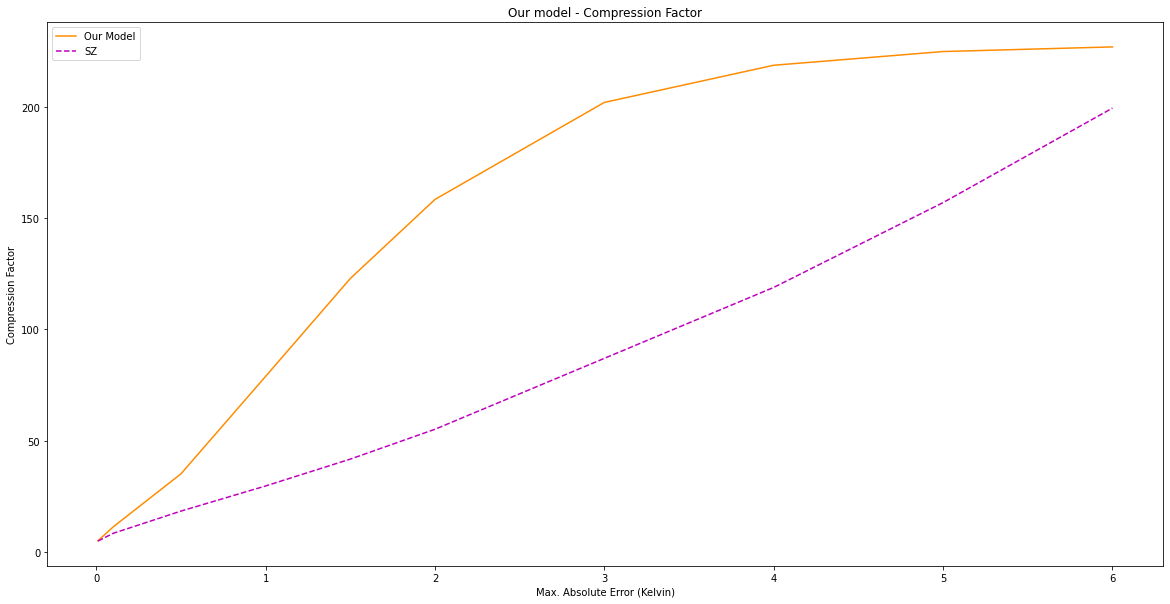

In [8]:
import matplotlib.pyplot as plt

SZ =[4.837075145272189, 8.329466010721887, 18.31723236300557, 29.620397591985665, 41.6872364125023, 55.10789837355161, 118.87714244253229, 157.0121056666635, 199.484717391239]

val = [0.01, 0.1, 0.5, 1, 1.5, 2, 4, 5, 6]
val1 = [0.01, 0.1, 0.5, 1, 1.5, 2, 3 ,4, 5, 6]

plt.figure(figsize=(20,10))
#plt.plot(val, all_values, 'b', label = "Our Model - All values")
#plt.plot(val, abs_values, '--g', label = "Out Model - Abs. values")
#plt.plot(val3, mft_values, '*r', label = "Out Model - Abs. values + MTF")
#plt.plot(val2, SZ, 'r',  label = "SZ")

plt.plot(val1, cf, 'darkorange', label = "Our Model")
plt.plot(val, SZ, '--m',  label = "SZ")
#plt.plot(val, ZFP, 'c',label = "ZFP")


#plt.axvline(x=15.740921)
plt.title('Our model - Compression Factor')
plt.xlabel('Max. Absolute Error (Kelvin)')
plt.ylabel('Compression Factor')
plt.legend(loc="upper left")

In [6]:
import pickle
with open('../lossycomp/threshold-model-history-16_1300_600.pkl', 'rb') as f:
    data = pickle.load(f)

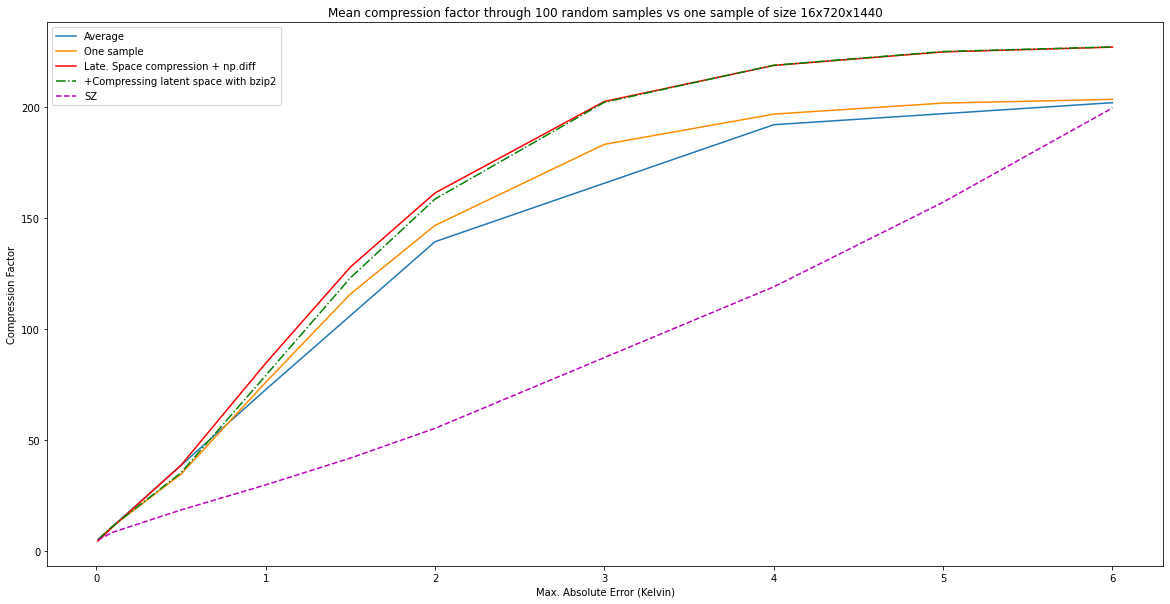

In [11]:
means = [] 
keys = [] 
for i in list(data['thresholds'].keys()):
    means.append(np.mean(data['thresholds'][i]))
    keys.append(float(i))

    
    
cf2 = [4.965214420965555,
 11.14531614272949,
 34.425453851198235,
 75.79527398958025,
 115.60199791984975,
 146.54222779733485,
 183.08367661706643,
 196.70474959535653,
 201.67527809859584,
 203.34894211674717]

cf3 = [4.299867884195326,
 10.921652705822867,
 38.43846070518476,
 84.4075209030579,
 127.7506103054993,
 161.15801233788312,
 202.41537199108038,
 218.63039696346672,
 224.74013811883367,
 226.8879633998728]

cf4 = [4.977389719326474,
 11.210860521129845,
 35.060247648082935,
 78.87878463678186,
 122.87135349734648,
 158.4291553653971,
 202.04310930178033,
 218.74571443641543,
 224.9100091516117,
 226.99352084345344]

plt.figure(figsize=(20,10))
val1 = [0.01, 0.1, 0.5, 1, 1.5, 2,3, 4, 5, 6]
val = [0.01, 0.1, 0.5, 1, 1.5, 2, 4, 5, 6]
plt.plot(keys, means, label = "Average")
plt.plot(val1, cf2, 'darkorange', label = "One sample")
plt.plot(val1, cf3, 'r' ,label = "Late. Space compression + np.diff")
plt.plot(val1, cf4, '-.g', label = "+Compressing latent space with bzip2")
plt.plot(val, SZ, '--m',  label = "SZ")
plt.title('Mean compression factor through 100 random samples vs one sample of size 16x720x1440')
plt.xlabel('Max. Absolute Error (Kelvin)')
plt.ylabel('Compression Factor')
plt.legend(loc="upper left")

In [12]:
means

[4.925570310592991,
 72.52698312545361,
 139.2071618783428,
 191.9292515058313,
 201.8581864513312]

In [94]:
import pickle
with open('../lossycomp/threshold-model-history.pkl', 'rb') as f:
    data_mod = pickle.load(f)

In [95]:
with open('../lossycomp/threshold-model-history-sz-2.pkl', 'rb') as f:
    data_sz = pickle.load(f)

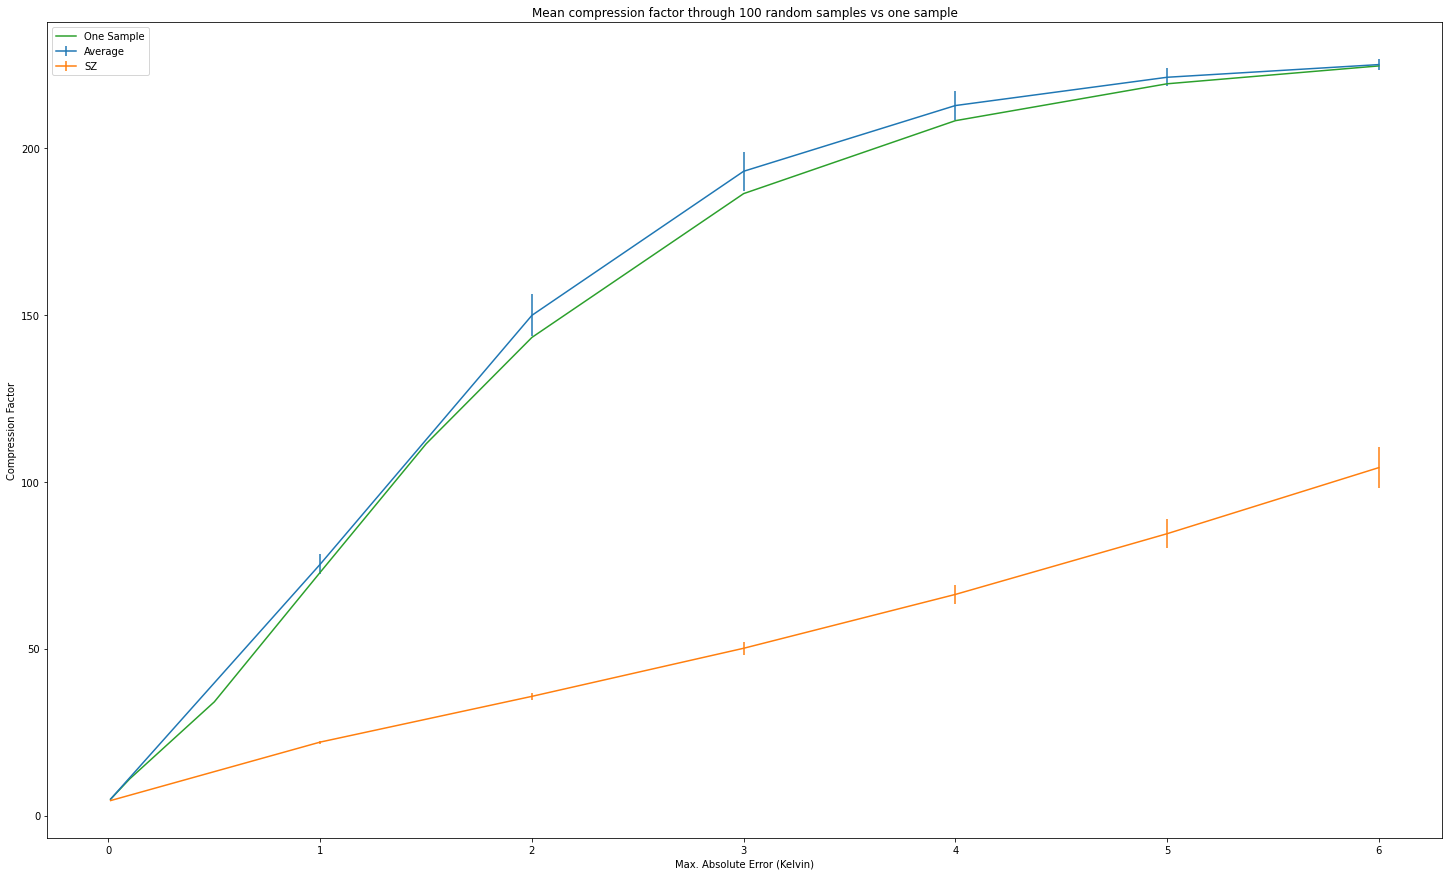

In [96]:
plt.figure(figsize=(25,15))

means_mod = [] 
std_mod = []
for i in list(data_mod['thresholds'].keys()):
    means_mod.append(np.mean(data_mod['thresholds'][i][0]))
    std_mod.append(np.std(data_mod['thresholds'][i]))
    
means_sz = [] 
std_sz = []
for i in list(data_sz['thresholds'].keys()):
    means_sz.append(np.mean(data_sz['thresholds'][i]))
    std_sz.append(np.std(data_sz['thresholds'][i]))


val = [0.01, 1, 2, 3, 4, 5, 6]
val1 = [0.01, 0.1, 0.5, 1, 1.5, 2, 3, 4, 5, 6]
plt.errorbar(val, means_mod, yerr = [std_mod,std_mod] , label = "Average")
plt.errorbar(val, means_sz, yerr = [std_sz, std_sz], label = "SZ")
plt.plot(val1, compress_laten,  label = "One Sample")
plt.title('Mean compression factor through 100 random samples vs one sample')
plt.xlabel('Max. Absolute Error (Kelvin)')
plt.ylabel('Compression Factor')
plt.legend(loc="upper left")

Text(0.5, 1.0, 'SZ vs our Model')

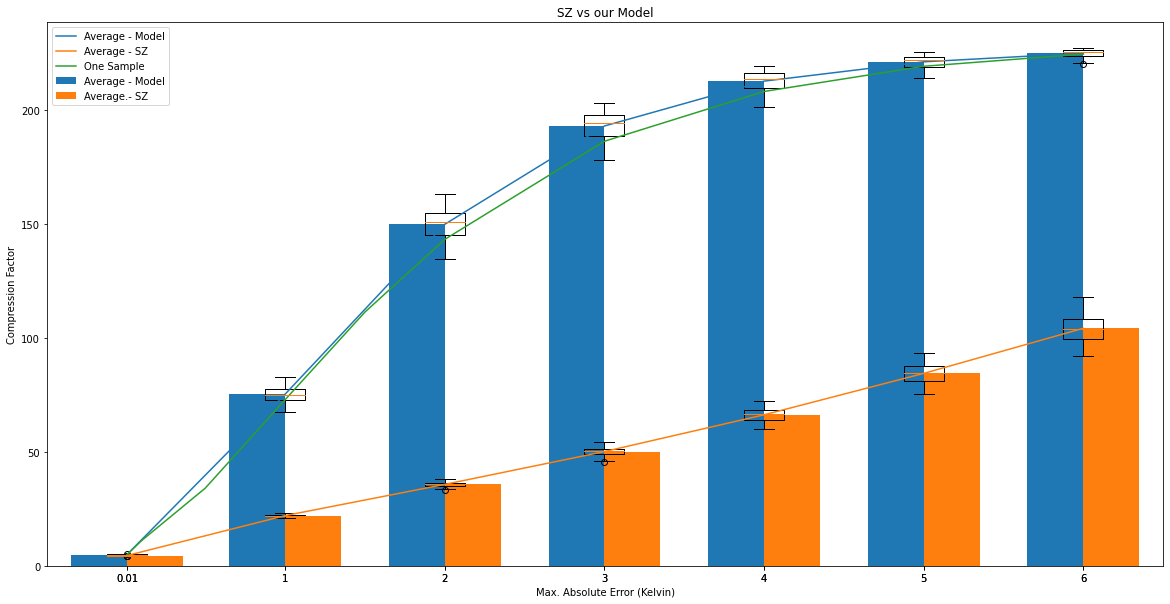

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

color_dict = {'trt_a':'orange', 'trt_b':'blue', 'trt_c':'green'}
controls = ['0.01', '1', '2', '3', '4', '5', '6']



fig, ax = plt.subplots(figsize=(20,10))

boxplot_dict = ax.boxplot(
    [data_mod['thresholds'][x][0] for x in data_mod['thresholds'].keys()],
    #positions = [1, 1.5, 2, 2.5, 3, 3.5, 4],
    positions = np.array([0.01,1,2,3,4,5,6]),
    labels = controls, 
    #patch_artist = True,
    widths = 0.25)

boxplot_dict = ax.boxplot(
    [data_sz['thresholds'][x][0] for x in data_sz['thresholds'].keys()],
    #positions = [1, 1.5, 2, 2.5, 3, 3.5, 4],
    positions = np.array([0.01,1,2,3,4,5,6]),
    labels = controls, 
    #patch_artist = True,
    widths = 0.25)

width = 0.35

ax.bar(np.array(val) - width/2, means_mod, width,label = "Average - Model")
ax.bar(np.array(val) + width/2, means_sz, width, label = "Average.- SZ")

ax.plot(val, means_mod, label = "Average - Model")
ax.plot(val, means_sz, label = "Average - SZ")

ax.plot(val1, compress_laten,  label = "One Sample")

ax.legend(loc="upper left")
ax.set_ylabel('Compression Factor')
ax.set_xlabel('Max. Absolute Error (Kelvin)')
ax.set_title("SZ vs our Model")

IndexError: list index out of range

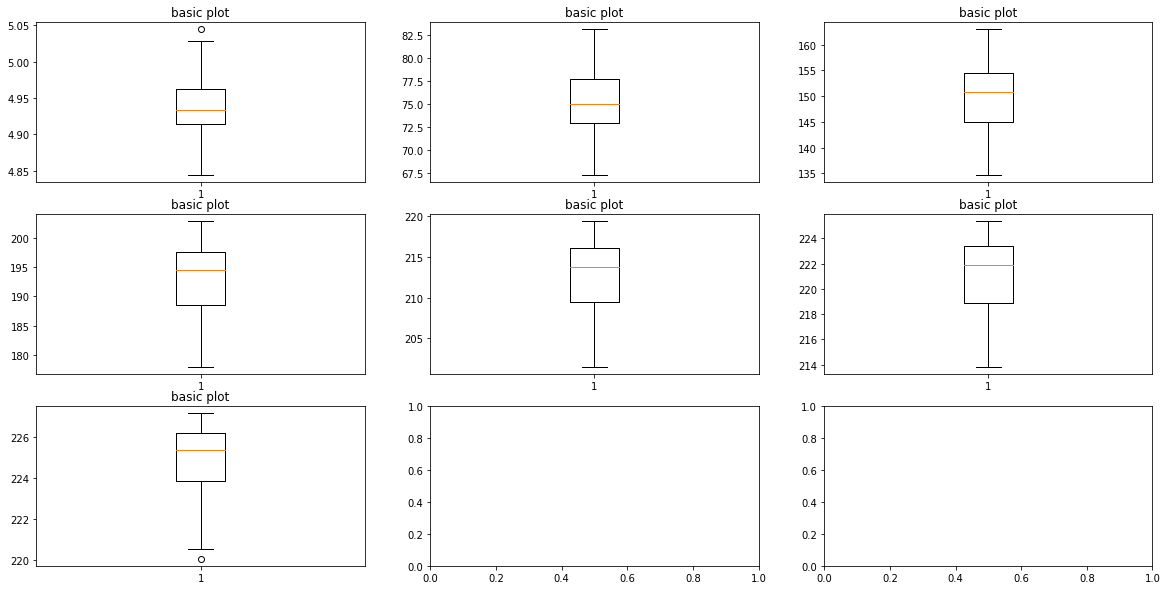

In [45]:
fig, axs = plt.subplots(3, 3, figsize=(20,10))

# basic plot
cnt = 0
key = data_mod['thresholds'].keys()
for i in range(3):
    for j in range(3):
        axs[i, j].boxplot(data_mod['thresholds'][list(key)[cnt]][0])
        axs[i, j].set_title('basic plot')
        cnt = cnt +1
        
        

In [44]:
len(key)

7